<a href="https://colab.research.google.com/github/srushtibit/POS-Tagger/blob/main/HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **POS tagging with Hidden Markov Model**

HMM (Hidden Markov Model) is a Stochastic technique for POS tagging. Hidden Markov models are known for their applications to reinforcement learning and temporal pattern recognition such as speech, handwriting, gesture recognition, musical score following, partial discharges, and bioinformatics.

**Implementation in Python**

In this section, we are going to use Python to code a POS tagging model based on the HMM and Viterbi algorithm.

In [ ]:
# Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time

#download the treebank corpus from nltk
nltk.download('treebank')

#download the universal tagset from nltk
nltk.download('universal_tagset')

# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

#print the first two sentences along with tags
print(nltk_data[:2])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [ ]:
#print each word with its respective tag for first two sentences
for sent in nltk_data[:2]:
  for tuple in sent:
    print(tuple)

('Pierre', 'NOUN')
('Vinken', 'NOUN')
(',', '.')
('61', 'NUM')
('years', 'NOUN')
('old', 'ADJ')
(',', '.')
('will', 'VERB')
('join', 'VERB')
('the', 'DET')
('board', 'NOUN')
('as', 'ADP')
('a', 'DET')
('nonexecutive', 'ADJ')
('director', 'NOUN')
('Nov.', 'NOUN')
('29', 'NUM')
('.', '.')
('Mr.', 'NOUN')
('Vinken', 'NOUN')
('is', 'VERB')
('chairman', 'NOUN')
('of', 'ADP')
('Elsevier', 'NOUN')
('N.V.', 'NOUN')
(',', '.')
('the', 'DET')
('Dutch', 'NOUN')
('publishing', 'VERB')
('group', 'NOUN')
('.', '.')


In [ ]:
# split data into training and validation set in the ratio 80:20
train_set,test_set =train_test_split(nltk_data,train_size=0.80,test_size=0.20,random_state = 101)


In [ ]:
# create list of train and test tagged words
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]
print(len(train_tagged_words))
print(len(test_tagged_words))

80310
20366


In [ ]:
# check some of the tagged words.
train_tagged_words[:5]

[('Drink', 'NOUN'),
 ('Carrier', 'NOUN'),
 ('Competes', 'VERB'),
 ('With', 'ADP'),
 ('Cartons', 'NOUN')]

In [ ]:
#use set datatype to check how many unique tags are present in training data
tags = {tag for word,tag in train_tagged_words}
print(len(tags))
print(tags)

# check total words in vocabulary
vocab = {word for word,tag in train_tagged_words}

12
{'DET', 'CONJ', 'ADP', 'ADV', '.', 'ADJ', 'PRT', 'NUM', 'PRON', 'VERB', 'NOUN', 'X'}


**Emission Probability** In a Hidden Markov Model (HMM), the emission probability is the probability of observing a particular output (such as a word) from a given hidden state (such as a Part-of-Speech tag). The emission probability is a crucial component of HMMs, especially in tasks like Part-of-Speech (POS) tagging, where you want to predict a sequence of tags (hidden states) given a sequence of words (observed states).

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ver.png to ver.png
Saving emission.png to emission (2).png


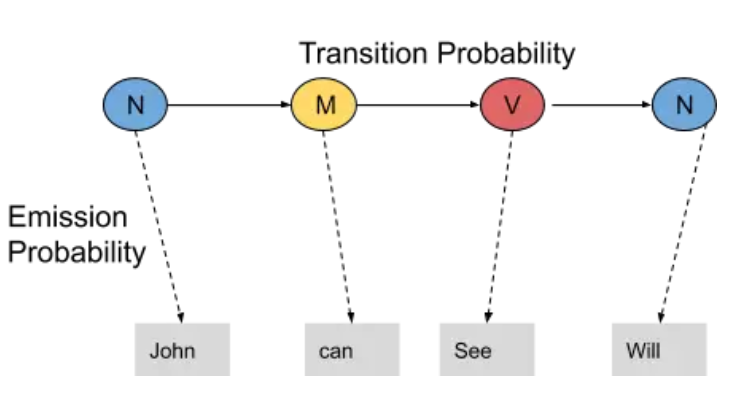

In [ ]:
from IPython.display import Image
Image('emission.png')

In [ ]:
# compute Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)#total number of times the passed tag occurred in train_bag
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
#now calculate the total number of times the passed word occurred as the passed tag.
    count_w_given_tag = len(w_given_tag_list)


    return (count_w_given_tag, count_tag)

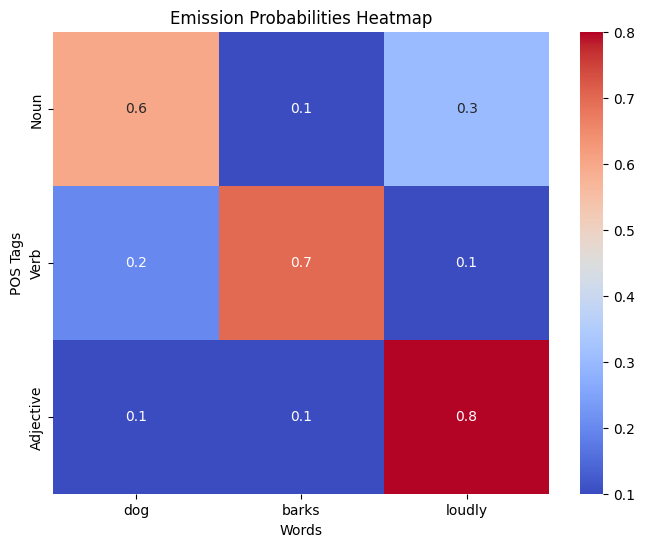

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example emission probabilities
emission_probs = {
    'Noun': {'dog': 0.6, 'barks': 0.1, 'loudly': 0.3},
    'Verb': {'dog': 0.2, 'barks': 0.7, 'loudly': 0.1},
    'Adjective': {'dog': 0.1, 'barks': 0.1, 'loudly': 0.8}
}

# Convert the dictionary to a DataFrame for visualization
import pandas as pd
df = pd.DataFrame(emission_probs).T

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Emission Probabilities Heatmap')
plt.xlabel('Words')
plt.ylabel('POS Tags')
plt.show()

**Transition Probability** In a Hidden Markov Model (HMM), the transition probability is the probability of moving from one hidden state to another. It is a crucial component in determining the sequence of hidden states that most likely explains the sequence of observed events (like words in a sentence).

In [ ]:
# compute  Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

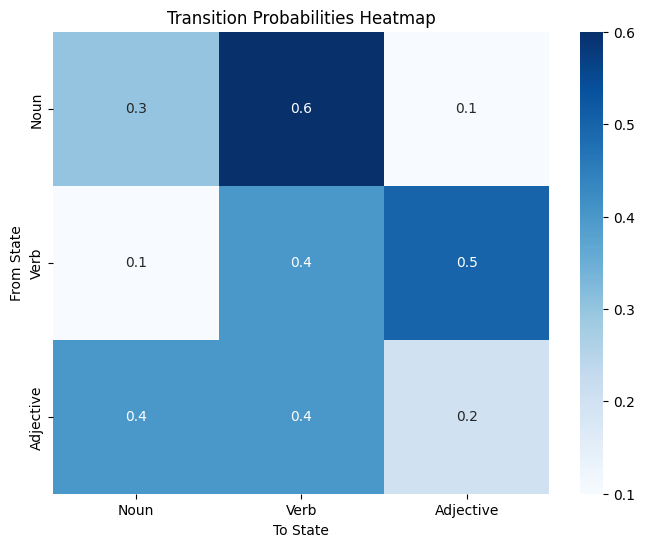

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example transition probability matrix
transition_probs = np.array([[0.3, 0.6, 0.1],
                             [0.1, 0.4, 0.5],
                             [0.4, 0.4, 0.2]])

states = ['Noun', 'Verb', 'Adjective']

plt.figure(figsize=(8, 6))
sns.heatmap(transition_probs, annot=True, cmap='Blues', xticklabels=states, yticklabels=states)
plt.title('Transition Probabilities Heatmap')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()


In [ ]:
# creating t x t transition matrix of tags, t= no of tags
# Matrix(i, j) represents P(jth tag after the ith tag)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

print(tags_matrix)

[[6.03708485e-03 4.31220367e-04 9.91806854e-03 1.20741697e-02
  1.73925534e-02 2.06410810e-01 2.87480245e-04 2.28546783e-02
  3.30602261e-03 4.02472317e-02 6.35906279e-01 4.51343954e-02]
 [1.23490669e-01 5.48847427e-04 5.59824370e-02 5.70801310e-02
  3.51262353e-02 1.13611415e-01 4.39077942e-03 4.06147093e-02
  6.03732169e-02 1.50384188e-01 3.49066973e-01 9.33040585e-03]
 [3.20931405e-01 1.01240189e-03 1.69577319e-02 1.45532778e-02
  3.87243740e-02 1.07061505e-01 1.26550242e-03 6.32751212e-02
  6.96026310e-02 8.47886596e-03 3.23588967e-01 3.45482156e-02]
 [7.13731572e-02 6.98215654e-03 1.19472459e-01 8.14584941e-02
  1.39255241e-01 1.30721495e-01 1.47401085e-02 2.98681147e-02
  1.20248254e-02 3.39022487e-01 3.21955010e-02 2.28859577e-02]
 [1.72191828e-01 6.00793920e-02 9.29084867e-02 5.25694676e-02
  9.23720598e-02 4.61323895e-02 2.78940029e-03 7.82104954e-02
  6.87694475e-02 8.96899477e-02 2.18538776e-01 2.56410260e-02]
 [5.24271838e-03 1.68932043e-02 8.05825219e-02 5.24271838e-03
  6

In [ ]:
# convert the matrix to a df for better readability
#the table is same as the transition table shown in section 3 of article
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
display(tags_df)

,DET,CONJ,ADP,ADV,.,ADJ,PRT,NUM,PRON,VERB,NOUN,X
DET,0.006037,0.000431,0.009918,0.012074,0.017393,0.206411,0.000287,0.022855,0.003306,0.040247,0.635906,0.045134
CONJ,0.123491,0.000549,0.055982,0.057080,0.035126,0.113611,0.004391,0.040615,0.060373,0.150384,0.349067,0.009330
ADP,0.320931,0.001012,0.016958,0.014553,0.038724,0.107062,0.001266,0.063275,0.069603,0.008479,0.323589,0.034548
ADV,0.071373,0.006982,0.119472,0.081458,0.139255,0.130721,0.014740,0.029868,0.012025,0.339022,0.032196,0.022886
.,0.172192,0.060079,0.092908,0.052569,0.092372,0.046132,0.002789,0.078210,0.068769,0.089690,0.218539,0.025641
ADJ,0.005243,0.016893,0.080583,0.005243,0.066019,0.063301,0.011456,0.021748,0.000194,0.011456,0.696893,0.020971
PRT,0.101370,0.002348,0.019569,0.009393,0.045010,0.082975,0.001174,0.056751,0.017613,0.401174,0.250489,0.012133
NUM,0.003570,0.014281,0.037487,0.003570,0.119243,0.035345,0.026062,0.184220,0.001428,0.020707,0.351660,0.202428
PRON,0.009567,0.005011,0.022323,0.036902,0.041913,0.070615,0.014123,0.006834,0.006834,0.484738,0.212756,0.088383
VERB,0.133610,0.005433,0.092357,0.083886,0.034807,0.066390,0.030663,0.022836,0.035543,0.167956,0.110589,0.215930


from matplotlib import pyplot as plt
tags_df['DET'].plot(kind='hist', bins=20, title='DET')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df['CONJ'].plot(kind='hist', bins=20, title='CONJ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df['ADP'].plot(kind='hist', bins=20, title='ADP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df['ADV'].plot(kind='hist', bins=20, title='ADV')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df.plot(kind='scatter', x='DET', y='CONJ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df.plot(kind='scatter', x='CONJ', y='ADP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df.plot(kind='scatter', x='ADP', y='ADV', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df.plot(kind='scatter', x='ADV', y='.', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tags_df['DET'].plot(kind='line', figsize=(8, 4), title='DET')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
tags_df['CONJ'].plot(kind='line', figsize=(8, 4), title='CONJ')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
tags_df['ADP'].plot(kind='line', figsize=(8, 4), title='ADP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
tags_df['ADV'].plot(kind='line', figsize=(8, 4), title='ADV')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['DET'].plot(kind='hist', bins=20, title='DET')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['CONJ'].plot(kind='hist', bins=20, title='CONJ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['ADP'].plot(kind='hist', bins=20, title='ADP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['ADV'].plot(kind='hist', bins=20, title='ADV')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='DET', y='CONJ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='CONJ', y='ADP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='ADP', y='ADV', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='ADV', y='.', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['DET'].plot(kind='line', figsize=(8, 4), title='DET')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['CONJ'].plot(kind='line', figsize=(8, 4), title='CONJ')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['ADP'].plot(kind='line', figsize=(8, 4), title='ADP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['ADV'].plot(kind='line', figsize=(8, 4), title='ADV')
plt.gca().spines[['top', 'right']].set_visible(False)

# Optimizing HMM with Viterbi Algorithm


The Viterbi algorithm is a dynamic programming algorithm for finding the most likely sequence of hidden states—called the Viterbi path—that results in a sequence of observed events, especially in the context of Markov information sources and hidden Markov models (HMM).

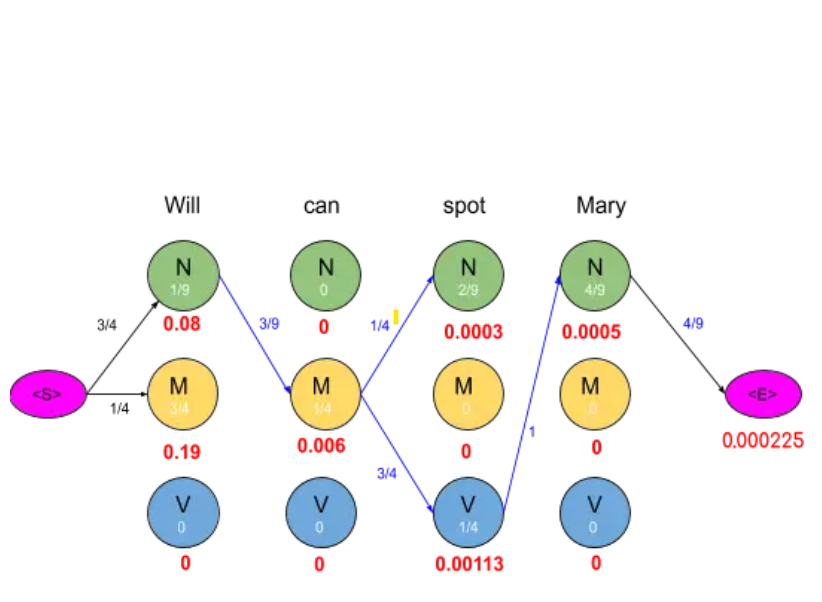

In [ ]:
from IPython.display import Image
Image('ver.png')

In [ ]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [ ]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(1234)      #define a random seed to get same sentences when run multiple times

# choose random 10 numbers
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of 10 sents on which we test the model
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [ ]:
#Here We will only test 10 sentences to check the accuracy
#as testing the whole training set takes huge amount of time
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Time taken in seconds:  35.76813077926636
Viterbi Algorithm Accuracy:  93.77990430622009


In [ ]:
#To improve the performance,we specify a rule base tagger for unknown words
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # verb
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [ ]:
#modified Viterbi to include rule based tagger in it
def Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]


        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]


        state.append(state_max)
    return list(zip(words, state))

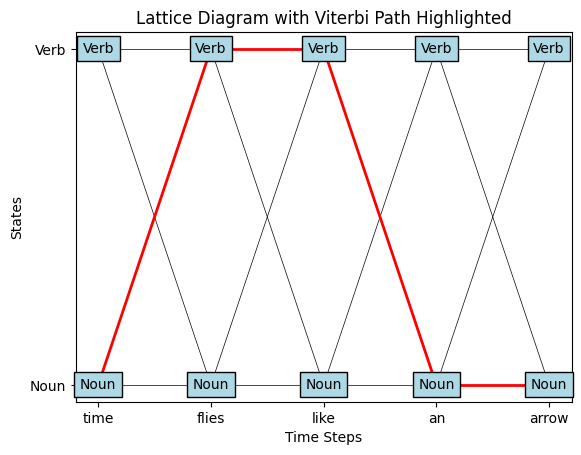

In [ ]:
# Generate lattice diagram with transitions and Viterbi path highlighted
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

# Nodes
for t in range(len(observations)):
    for state in states:
        ax.text(t, states.index(state), state, ha='center', va='center',
                bbox=dict(facecolor='lightblue', edgecolor='black'))

# Edges
for t in range(1, len(observations)):
    for state_from in states:
        for state_to in states:
            ax.plot([t-1, t], [states.index(state_from), states.index(state_to)], 'k-', lw=0.5)

# Highlight Viterbi Path
for t in range(len(best_path) - 1):
    ax.plot([t, t + 1], [states.index(best_path[t]), states.index(best_path[t + 1])],
            'r-', lw=2)

plt.xticks(range(len(observations)), observations)
plt.yticks(range(len(states)), states)
plt.title('Lattice Diagram with Viterbi Path Highlighted')
plt.xlabel('Time Steps')
plt.ylabel('States')

plt.show()


In [ ]:
import numpy as np

# Define the states, observations, and initial probabilities
states = ['Noun', 'Verb']
observations = ['time', 'flies', 'like', 'an', 'arrow']
start_prob = {'Noun': 0.6, 'Verb': 0.4}
trans_prob = {'Noun': {'Noun': 0.3, 'Verb': 0.7},
              'Verb': {'Noun': 0.8, 'Verb': 0.2}}
emit_prob = {'Noun': {'time': 0.5, 'flies': 0.1, 'like': 0.1, 'an': 0.1, 'arrow': 0.2},
             'Verb': {'time': 0.1, 'flies': 0.6, 'like': 0.3, 'an': 0.0, 'arrow': 0.0}}

def viterbi(obs, states, start_p, trans_p, emit_p):
    T = len(obs)
    N = len(states)

    # Initialize the delta and psi tables
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)

    # Initialization step
    for i in range(N):
        delta[0, i] = start_p[states[i]] * emit_p[states[i]].get(obs[0], 0)
        psi[0, i] = 0

    # Recursion step
    for t in range(1, T):
        for j in range(N):
            max_prob = delta[t-1, 0] * trans_p[states[0]][states[j]]
            max_state = 0
            for i in range(1, N):
                prob = delta[t-1, i] * trans_p[states[i]][states[j]]
                if prob > max_prob:
                    max_prob = prob
                    max_state = i
            delta[t, j] = max_prob * emit_p[states[j]].get(obs[t], 0)
            psi[t, j] = max_state

    # Termination step
    best_path_prob = np.max(delta[T-1])
    best_last_state = np.argmax(delta[T-1])

    # Path backtracking
    best_path = [best_last_state]
    for t in range(T-1, 0, -1):
        best_path.insert(0, psi[t, best_path[0]])

    best_path_states = [states[i] for i in best_path]

    return best_path_states, best_path_prob

# Running the Viterbi algorithm
best_path, best_prob = viterbi(observations, states, start_prob, trans_prob, emit_prob)
print(f"Best path: {best_path}")
print(f"Best path probability: {best_prob}")


Best path: ['Noun', 'Verb', 'Verb', 'Noun', 'Noun']
Best path probability: 3.628800000000001e-05


In [ ]:
#test accuracy on subset of test data
start = time.time()
tagged_seq = Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Time taken in seconds:  33.587154388427734
Viterbi Algorithm Accuracy:  97.1291866028708
